**Step 1:** Collecting Datasets

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [8]:
url = "/kaggle/input/chest-xray-pneumonia"
!pip install -q tensorflow

In [9]:
!pip install -q opencv-python

In [17]:
# Connect to TPU
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print('Running on TPU:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print('TPU not found. Using default strategy.')
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


TPU not found. Using default strategy.
REPLICAS:  1


 **Step 2:** Import Libraries

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Step 3 :** Visualize the Data?

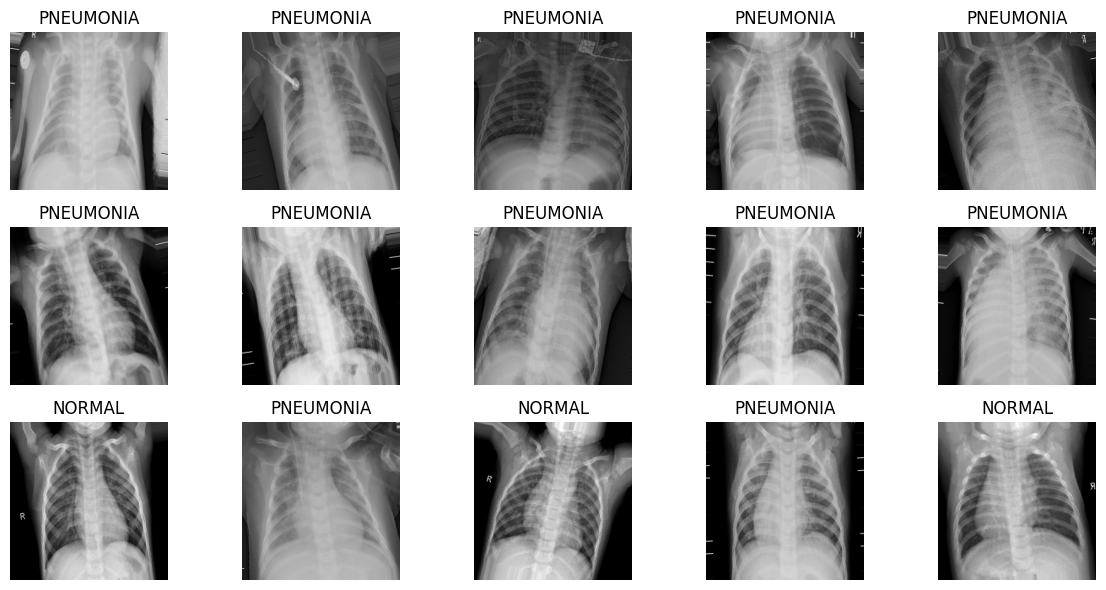

In [12]:
import matplotlib.pyplot as plt
# Function to plot images with labels
def plot_images(images_arr, labels):
    plt.figure(figsize=(12, 6))
    for i in range(len(images_arr)):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images_arr[i])
        plt.title("PNEUMONIA" if labels[i] == 1 else "NORMAL")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the first 15 images
plot_images(images[:15], labels[:15])


**Step 4:** Prepare the Data Pipeline (for TPU training).

In [14]:
# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


**Step 5:** Build the CNN Model

In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

with strategy.scope():  # This makes the model TPU-compatible
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False  # Freeze base for feature extraction

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Step 6:** Compile & Train the Model!

In [19]:
EPOCHS = 10  # You can increase later after testing

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=100,
    validation_steps=20,
    validation_data=val_ds
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.8009 - loss: 0.4644 - val_accuracy: 0.8125 - val_loss: 0.4117
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9340 - loss: 0.1543 - val_accuracy: 0.8125 - val_loss: 0.2238
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9441 - loss: 0.1439 - val_accuracy: 0.8125 - val_loss: 0.4731
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9608 - loss: 0.1081 - val_accuracy: 0.8750 - val_loss: 0.2504
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9552 - loss: 0.1222 - val_accuracy: 0.8125 - val_loss: 0.2743
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9567 - loss: 0.1077 - val_accuracy: 0.8750 - val_loss: 0.2731
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9604 - loss: 0.1053 - val_accuracy: 0.8125 - val_loss: 0.3372
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9560 - loss: 0.1068 - val_accu

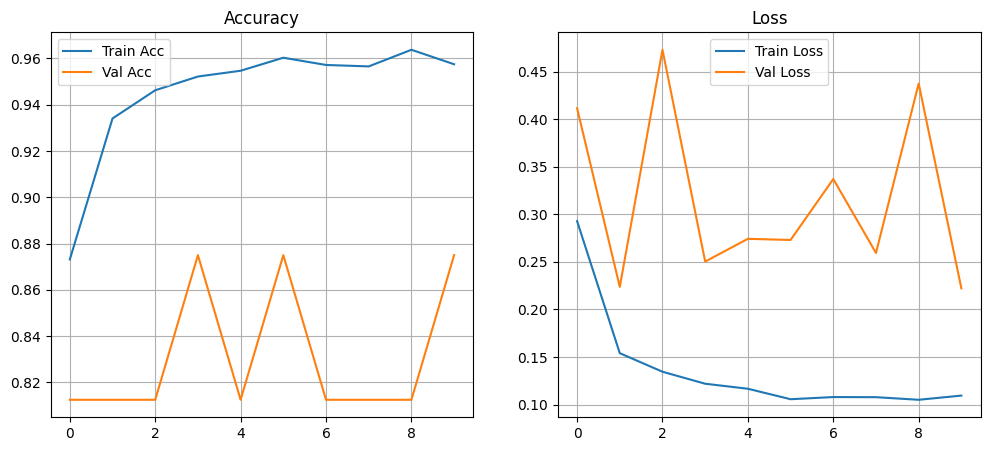

In [20]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid()

plt.show()

**Step 7:** Evaluate the Model on the Test Set.

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8120 - loss: 0.4257
Subset Test Loss: 0.6986
Subset Test Accuracy: 0.6938


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         0
   PNEUMONIA       1.00      0.72      0.84       160

    accuracy                           0.72       160
   macro avg       0.50      0.36      0.42       160
weighted avg       1.00      0.72      0.84       160



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


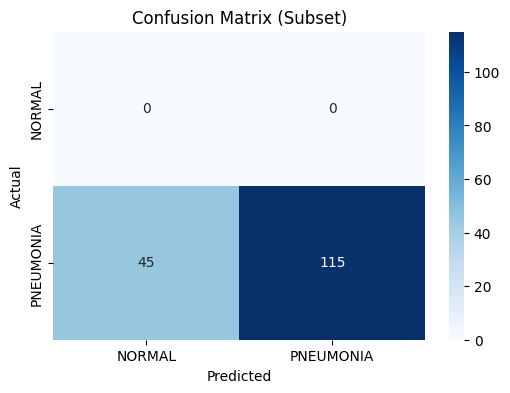

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Take a subset of the test dataset for quick evaluation
subset_test_ds = test_ds.take(5)  # e.g., take first 5 batches only

# Evaluate the model on the subset
loss, accuracy = model.evaluate(subset_test_ds)
print(f"Subset Test Loss: {loss:.4f}")
print(f"Subset Test Accuracy: {accuracy:.4f}")

# Get predictions from subset
y_pred_probs = model.predict(subset_test_ds, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Manually extract labels from the subset
y_true = []
for _, label_batch in subset_test_ds:
    y_true.extend(label_batch.numpy())
y_true = np.array(y_true).astype(int)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Subset)')
plt.show()


**Step 8:** Make Predictions & Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


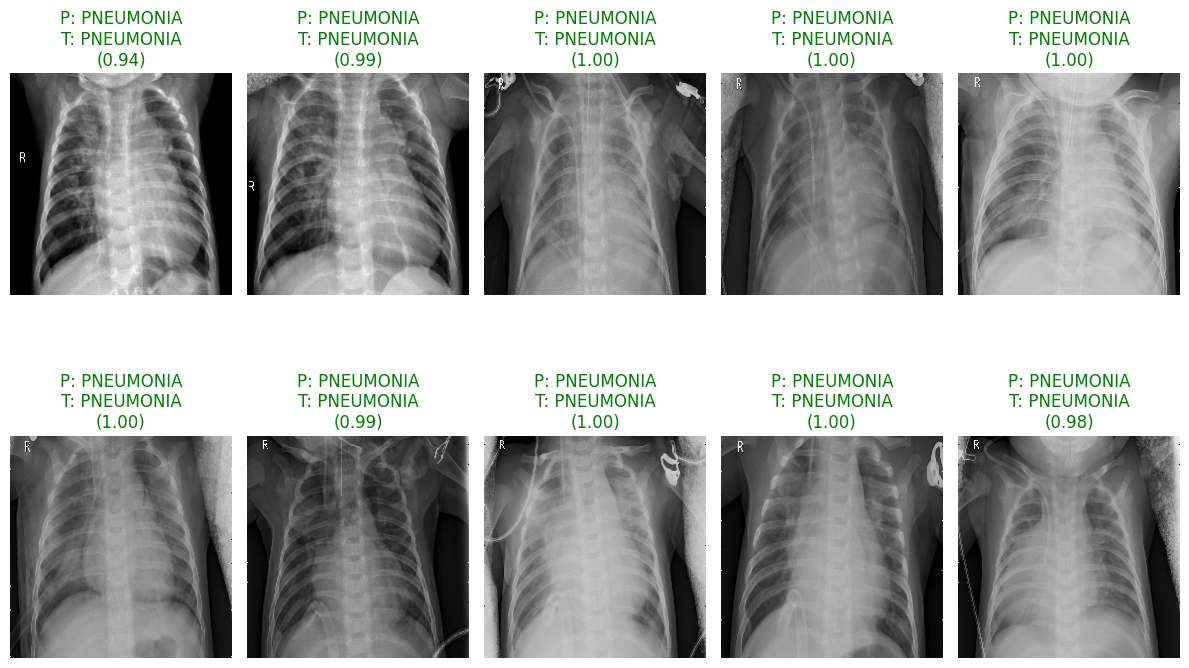

In [22]:
# Load test data (images and labels)
test_images, test_labels = next(test_generator)

# Get predictions
pred_probs = model.predict(test_images)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Plot predictions
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
    true_label = "PNEUMONIA" if test_labels[i] == 1 else "NORMAL"
    pred_label = "PNEUMONIA" if pred_labels[i] == 1 else "NORMAL"
    confidence = pred_probs[i][0]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}\n({confidence:.2f})", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()
